In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.stats.power import FTestAnovaPower
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
# Đọc dữ liệu
data = pd.read_csv('ys1a.csv')

data = data.dropna(subset=["ys"])
# Xác định các biến độc lập và phụ thuộc
X = data[['vec', 'deltachi', 'delta', 'deltahmix', 'deltasmix']]
y = data['ys']

print(data)

             composition       vec  deltachi     delta  deltahmix  deltasmix  \
0                 CoFeNi  9.000000  0.032998  0.327647  -1.333333   9.134371   
1                 CoFeNi  9.000000  0.032998  0.327647  -1.333333   9.134371   
2                 CoFeNi  9.000000  0.032998  0.327647  -1.333333   9.134371   
3           CoFeNiSi0.25  8.615385  0.032490  2.025282 -11.834320  10.686521   
4            CoFeNiSi0.5  8.285714  0.031944  2.657710 -19.428571  11.239357   
..                   ...       ...       ...       ...        ...        ...   
372  AlCrFeNiMo0.5Ti0.25  6.526316  0.177240  6.525834 -14.670360  14.168429   
373   AlCrFeNiMo0.5Ti0.4  6.448980  0.179505  6.711707 -16.059975  14.423628   
374   AlCrFeNiMo0.5Ti0.5  6.400000  0.180765  6.815761 -16.880000  14.534241   
375   AlCrFeNiMo0.5Ti0.6  6.352941  0.181852  6.906416 -17.623991  14.610949   
376  AlCrFeNiMo0.5Ti0.75  6.285714  0.183197  7.020976 -18.612245  14.677850   

     ref   phase  density     hv testty

In [61]:
# Thông số thiết kế thí nghiệm
alpha = 0.05  # Mức ý nghĩa
power = 0.8   # Power
effect_size = 0.5  # Ước tính kích thước hiệu ứng (medium effect size)

# Ước tính số lần lặp (replication) cần thiết
anova_power = FTestAnovaPower()
sample_size = anova_power.solve_power(effect_size=effect_size, alpha=alpha, power=power, k_groups=3)
replications = int(np.ceil(sample_size))
print(f"Số lần lặp cần thiết: {replications}")

Số lần lặp cần thiết: 42


In [44]:
# Thiết lập thí nghiệm với các tỷ lệ kiểm thử
test_sizes = [0.1, 0.2, 0.3]
random_seed = 42
results = []

# Lặp qua các lần thí nghiệm
for test_size in test_sizes:
    for i in range(replications):
        np.random.seed(random_seed)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_seed + i)
        
        # Hồi quy tuyến tính
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Tính toán RMSE và MAPE
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred) * 100
        
        # Lưu kết quả
        results.append({
            'Test Size': test_size,
            'Replication': i + 1,
            'RMSE': rmse,
            'MAPE': mape
        })

# Tổng hợp kết quả
results_df = pd.DataFrame(results)
print(results_df)

     Test Size  Replication        RMSE       MAPE
0          0.1            1  477.540200  59.616594
1          0.1            2  486.510307  51.613403
2          0.1            3  444.819838  66.354503
3          0.1            4  537.165597  39.038216
4          0.1            5  477.062891  45.142570
..         ...          ...         ...        ...
121        0.3           38  506.176723  53.085321
122        0.3           39  473.826462  50.272294
123        0.3           40  455.960308  38.887268
124        0.3           41  503.498785  48.430730
125        0.3           42  431.275507  51.923457

[126 rows x 4 columns]


In [45]:
# Xuất kết quả ra file CSV ngay sau khi tạo DataFrame
results_df.to_csv('crd_results.csv', index=False)
print("Kết quả thí nghiệm đã được lưu vào file 'crd_results.csv'.")

Kết quả thí nghiệm đã được lưu vào file 'crd_results.csv'.


In [46]:
# Phân tích ANOVA cho RMSE
f_stat_rmse, p_value_rmse = f_oneway(
    results_df[results_df['Test Size'] == 0.1]['RMSE'],
    results_df[results_df['Test Size'] == 0.2]['RMSE'],
    results_df[results_df['Test Size'] == 0.3]['RMSE']
)

# Phân tích ANOVA cho MAPE
f_stat_mape, p_value_mape = f_oneway(
    results_df[results_df['Test Size'] == 0.1]['MAPE'],
    results_df[results_df['Test Size'] == 0.2]['MAPE'],
    results_df[results_df['Test Size'] == 0.3]['MAPE']
)

In [62]:
# In kết quả ANOVA
print(f"ANOVA RMSE: F-statistic = {f_stat_rmse:.4f}, p-value = {p_value_rmse:.4f}")
print(f"ANOVA MAPE: F-statistic = {f_stat_mape:.4f}, p-value = {p_value_mape:.4f}")

ANOVA RMSE: F-statistic = 0.1165, p-value = 0.8902
ANOVA MAPE: F-statistic = 0.0496, p-value = 0.9516


In [63]:
if p_value_rmse < 0.05:
    print(f"ANOVA RMSE: Có sự khác biệt đáng kể giữa các tỷ lệ kiểm thử (p-value = {p_value_rmse:.4f}).")
else:
    print(f"ANOVA RMSE: Không có sự khác biệt đáng kể giữa các tỷ lệ kiểm thử (p-value = {p_value_rmse:.4f}).")

if p_value_mape < 0.05:
    print(f"ANOVA MAPE: Có sự khác biệt đáng kể giữa các tỷ lệ kiểm thử (p-value = {p_value_mape:.4f}).")
else:
    print(f"ANOVA MAPE: Không có sự khác biệt đáng kể giữa các tỷ lệ kiểm thử (p-value = {p_value_mape:.4f}).")


ANOVA RMSE: Không có sự khác biệt đáng kể giữa các tỷ lệ kiểm thử (p-value = 0.8902).
ANOVA MAPE: Không có sự khác biệt đáng kể giữa các tỷ lệ kiểm thử (p-value = 0.9516).


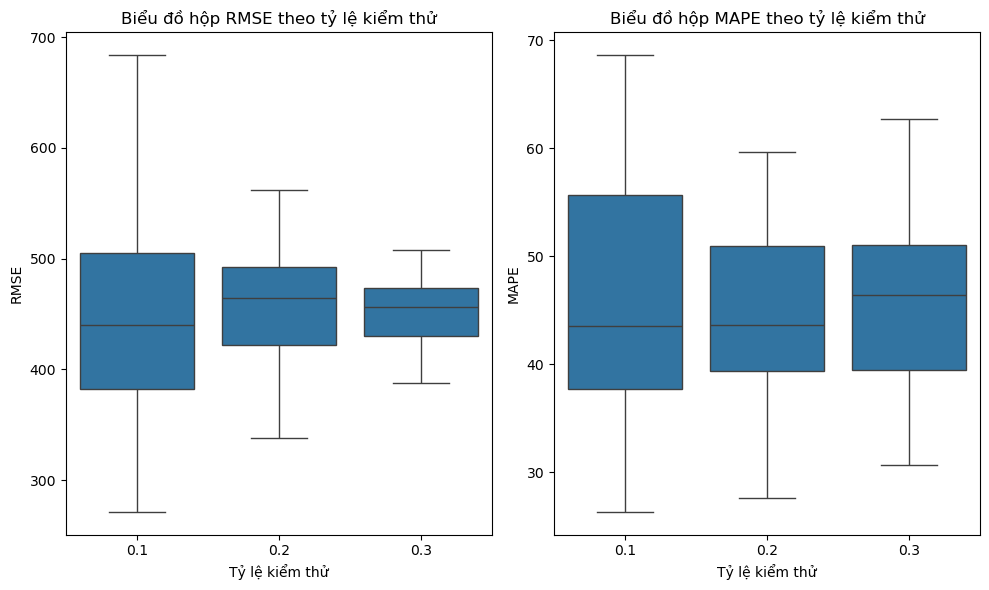

In [51]:
# Tạo biểu đồ hộp (Boxplot) cho RMSE và MAPE theo các tỷ lệ kiểm thử
plt.figure(figsize=(10, 6))

# Biểu đồ hộp cho RMSE
plt.subplot(1, 2, 1)
sns.boxplot(x='Test Size', y='RMSE', data=results_df)
plt.title('Biểu đồ hộp RMSE theo tỷ lệ kiểm thử')
plt.xlabel('Tỷ lệ kiểm thử')
plt.ylabel('RMSE')

# Biểu đồ hộp cho MAPE
plt.subplot(1, 2, 2)
sns.boxplot(x='Test Size', y='MAPE', data=results_df)
plt.title('Biểu đồ hộp MAPE theo tỷ lệ kiểm thử')
plt.xlabel('Tỷ lệ kiểm thử')
plt.ylabel('MAPE')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

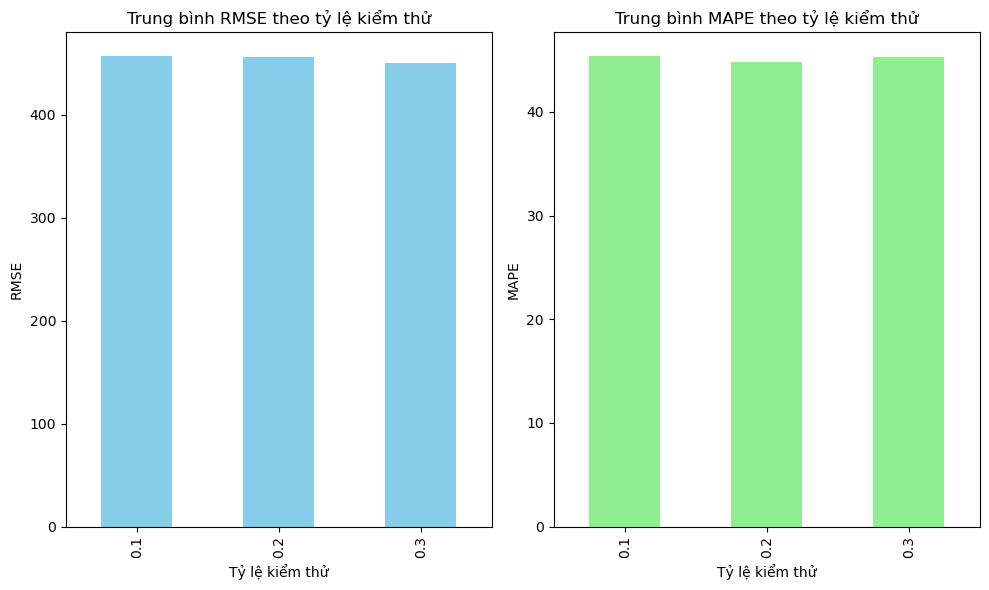

In [53]:
# Tạo biểu đồ cột (Bar chart) cho RMSE và MAPE trung bình theo các tỷ lệ kiểm thử
mean_rmse = results_df.groupby('Test Size')['RMSE'].mean()
mean_mape = results_df.groupby('Test Size')['MAPE'].mean()

plt.figure(figsize=(10, 6))
# Biểu đồ cột cho RMSE
plt.subplot(1, 2, 1)
mean_rmse.plot(kind='bar', color='skyblue')
plt.title('Trung bình RMSE theo tỷ lệ kiểm thử')
plt.xlabel('Tỷ lệ kiểm thử')
plt.ylabel('RMSE')

# Biểu đồ cột cho MAPE
plt.subplot(1, 2, 2)
mean_mape.plot(kind='bar', color='lightgreen')
plt.title('Trung bình MAPE theo tỷ lệ kiểm thử')
plt.xlabel('Tỷ lệ kiểm thử')
plt.ylabel('MAPE')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

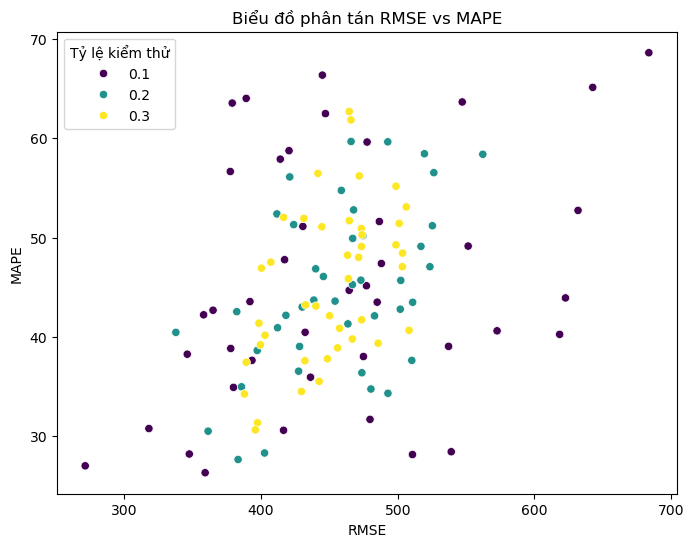

In [54]:
# Tạo biểu đồ phân tán (Scatter plot) giữa RMSE và MAPE
plt.figure(figsize=(8, 6))
sns.scatterplot(x='RMSE', y='MAPE', data=results_df, hue='Test Size', palette='viridis')
plt.title('Biểu đồ phân tán RMSE vs MAPE')
plt.xlabel('RMSE')
plt.ylabel('MAPE')
plt.legend(title='Tỷ lệ kiểm thử')
plt.show()